In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'C:\\Users\\Noah\\CovidMobile'

# Census Data

In [3]:
df_col_headers = pd.read_csv('data/DataDict.txt_2020-04-16', sep='\t', header=None)
df_county_data = pd.read_csv('data/DataSet.txt_2020-04-16', sep=',')
df_county_names = pd.read_csv('data/FIPS_CountyName.txt_2020-04-16', sep='delimiter', header=None)

C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
df_county_names.tail()

,0
3190,"56037 Sweetwater County, WY"
3191,"56039 Teton County, WY"
3192,"56041 Uinta County, WY"
3193,"56043 Washakie County, WY"
3194,"56045 Weston County, WY"


In [5]:
df_county_names = df_county_names[0].str.split(' ',n=1,expand=True)
df_county_names = pd.concat([df_county_names[0],df_county_names[1].str.split(',',n=1,expand=True)],axis=1)
df_county_names.columns = ['FIPS','County','State']
df_county_names['State'] = df_county_names['State'].str.replace(' ', '')
df_county_names.shape,df_county_names.head()

((3195, 3),     FIPS          County State
 0  00000   UNITED STATES  None
 1  01000         ALABAMA  None
 2  01001  Autauga County    AL
 3  01003  Baldwin County    AL
 4  01005  Barbour County    AL)

In [6]:
df_col_headers = df_col_headers[0].str.split(' ',n=1,expand=True)
df_col_headers = pd.concat([df_col_headers[0],df_col_headers[1].str.split('\s+\s+',n=1,expand=True)],axis=1)
df_col_headers.columns = ['code','var_name','extra']
df_col_headers.drop([0],inplace=True)
df_col_headers.head()



,code,var_name,extra
1,STATECOU,FIPS State and County code,None
2,PST045214,"Population, 2014 estimate",ABS 0 318857056 86 318857056 CENSUS
3,PST045213,"Population, 2013 estimate",ABS 0 316497531 89 316497531 CENSUS
4,PST040210,"Population, 2010 (April 1) estimates base",ABS 0 308758105 82 308758105 CENSUS
5,PST120214,"Population, percent change - April 1, 2010 to ...",PCT 1 3.3 -17.0 72.9 CENSUS


In [7]:
df_county_data.columns = df_col_headers['var_name'].values

In [8]:
df_county_data.head()

,FIPS State and County code,"Population, 2014 estimate","Population, 2013 estimate","Population, 2010 (April 1) estimates base","Population, percent change - April 1, 2010 to July 1, 2014","Population, percent change - April 1, 2010 to July 1, 2013","Population, 2010","Persons under 5 years, percent, 2013","Persons under 18 years, percent, 2013","Persons 65 years and over, percent, 2013",...,"Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010"
0,0,318857056,316497531,308758105,3.3,2.5,308745538,6.3,23.3,14.1,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,4849377,4833996,4780127,1.4,1.1,4779736,6.1,23.0,14.9,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,55395,55136,54571,1.5,1.0,54571,6.1,25.4,13.5,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,200111,195443,182265,9.8,7.2,182265,5.7,22.4,18.1,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,26887,26978,27457,-2.1,-1.7,27457,5.8,21.1,15.9,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0


# Build Dataset

In [9]:
first = 'data/US-'
last = '_2020-04-05.csv'

In [10]:
os.getcwd()

'C:\\Users\\Noah\\CovidMobile'

In [11]:
full = pd.read_csv('data/Global_Mobility_Report.csv')
full['source'] = 'google'

full.replace({'transit_stations_percent_change_from_baseline':'transit',
                 'residential_percent_change_from_baseline':'homes',
                 'grocery_and_pharmacy_percent_change_from_baseline':'food_drugs',
                'retail_and_recreation_percent_change_from_baseline':'retail',
                'workplaces_percent_change_from_baseline':'work',
                'parks_percent_change_from_baseline':'park'},inplace=True)


C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
full.columns.values

array(['country_region_code', 'country_region', 'sub_region_1',
       'sub_region_2', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'source'], dtype=object)

In [13]:
full = full[full['country_region_code']=='US'].rename(columns={'sub_region_1':'state','sub_region_2':'county'}) 

In [14]:
full['state_abb'] = full['state'].apply(replace_acronym)
full['county'] = np.where(full['county'].isnull(),full['state_abb'] ,full['county'] )

In [15]:
df_county_names['Region'] = np.where(df_county_names['State'].isnull(),np.nan,df_county_names['County'])
df_county_names['State'] = df_county_names['State'].fillna(method='backfill')
df_county_names['Region'] = np.where(df_county_names['Region'].isnull(),df_county_names['State'],df_county_names['Region'])
print(df_county_names.head())
df_county_names.drop([0],inplace=True)
df_county_names.rename(columns={'State':'state_abb','Region':'county'},inplace=True)

    FIPS          County State          Region
0  00000   UNITED STATES    AL              AL
1  01000         ALABAMA    AL              AL
2  01001  Autauga County    AL  Autauga County
3  01003  Baldwin County    AL  Baldwin County
4  01005  Barbour County    AL  Barbour County


In [16]:
replc_county = {'Anchorage' :'Anchorage Municipality',
'Bethel' :'Bethel Census Area',
'Fairbanks North Star' :'Fairbanks North Star Borough',
'Juneau' : 'Juneau City and Borough',
'Kenai Peninsula Borough' :'Kenai Peninsula Borough',
'Ketchikan Gateway' :'Ketchikan Gateway Borough',
'Kodiak Island':'Kodiak Island Borough',
'Matanuska-Susitna':'Matanuska-Susitna Borough',
'North Slope':'North Slope Borough',
'Sitka':'Sitka City and Borough',
'Southeast Fairbanks':'Southeast Fairbanks Census Area',
'Valdez-Cordova':'Valdez-Cordova Census Area',
'Doña Ana County':'Doa Ana'}

In [17]:
df_county_data.rename(columns={' FIPS State and County code':'FIPS'},inplace=True)
df_county_data['FIPS'] = df_county_data['FIPS'].astype(float)
df_county_names['county'] = df_county_names['county'].str.replace(' city','')
full['county'] = full['county'].replace(replc_county)
full_tog = full.merge(df_county_names[['FIPS','state_abb','county']],on=['state_abb','county'],how='left')
full_tog['FIPS'] = full_tog['FIPS'].astype(float)
full_tog = full_tog.merge(df_county_data,on=['FIPS'],how='left',indicator=True)

In [18]:
full_tog[(full_tog['_merge']=='left_only')][['state','county']].drop_duplicates()

,state,county
0,NaN,None
88168,New Mexico,Doa Ana


In [19]:
df_county_names[df_county_names['county']=='NM']['county'].value_counts()

NM    1
Name: county, dtype: int64

In [20]:
print(full_tog['_merge'].value_counts())
full_tog.drop(columns=['_merge'],inplace=True)

both          154946
left_only        114
right_only         0
Name: _merge, dtype: int64


In [21]:
full_tog.date = pd.to_datetime(full_tog.date,errors='coerce') 
full_tog['geo']=np.where(full_tog['county']==full_tog['state_abb'],'state','county')

# Covid Data (source: NYT)

In [22]:
lst_download = '2020-04-17'

In [23]:
covid_county = pd.read_csv('data/us-counties.csv_{}'.format(lst_download),encoding = "ISO-8859-1")
covid_state = pd.read_csv('data/us-states.csv_{}'.format(lst_download),encoding = "ISO-8859-1")

In [24]:
covid_state['state_abb'] = covid_state['state'].apply(replace_acronym)
covid_state['county'] = covid_state['state_abb'].copy()
covid_state['fips'] = covid_state['fips'] *1000.0
covid_county['state_abb'] = covid_county['state'].apply(replace_acronym)
covid = pd.concat([covid_state,covid_county],axis=0)
covid.date = pd.to_datetime(covid.date,errors='coerce')
covid.rename(columns={'fips':'FIPS'},inplace=True)
covid['FIPS'] = covid['FIPS'].astype(float)
print(covid.groupby(['FIPS']).first())
print(covid.shape)
covid.dropna(subset=['FIPS'],inplace=True)
covid[covid['date']>=pd.to_datetime('2020-02-15')].shape

              date                     state  cases  deaths state_abb   county
FIPS                                                                          
1000.0  2020-03-13                   Alabama      6       0        AL       AL
1001.0  2020-03-24                   Alabama      1       0        AL  Autauga
1003.0  2020-03-14                   Alabama      1       0        AL  Baldwin
1005.0  2020-04-03                   Alabama      1       0        AL  Barbour
1007.0  2020-03-30                   Alabama      2       0        AL     Bibb
...            ...                       ...    ...     ...       ...      ...
60000.0 2020-04-09            American Samoa      0       0        AS       AS
66000.0 2020-03-15                      Guam      3       0        GU       GU
69000.0 2020-03-28  Northern Mariana Islands      2       0        MP       MP
72000.0 2020-03-13               Puerto Rico      3       0        PR       PR
78000.0 2020-03-14            Virgin Islands      1 

(66083, 7)

In [25]:
full_tog.head()

,country_region_code,country_region,state,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,...,"Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010",geo
0,US,United States,NaN,None,2020-02-15,6.0,2.0,15.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,county
1,US,United States,NaN,None,2020-02-16,7.0,1.0,16.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,county
2,US,United States,NaN,None,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,county
3,US,United States,NaN,None,2020-02-18,0.0,-1.0,6.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,county
4,US,United States,NaN,None,2020-02-19,2.0,0.0,8.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,county


In [26]:
full_data = full_tog.merge(covid,on=['date','FIPS'],how='left',indicator=True)

C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


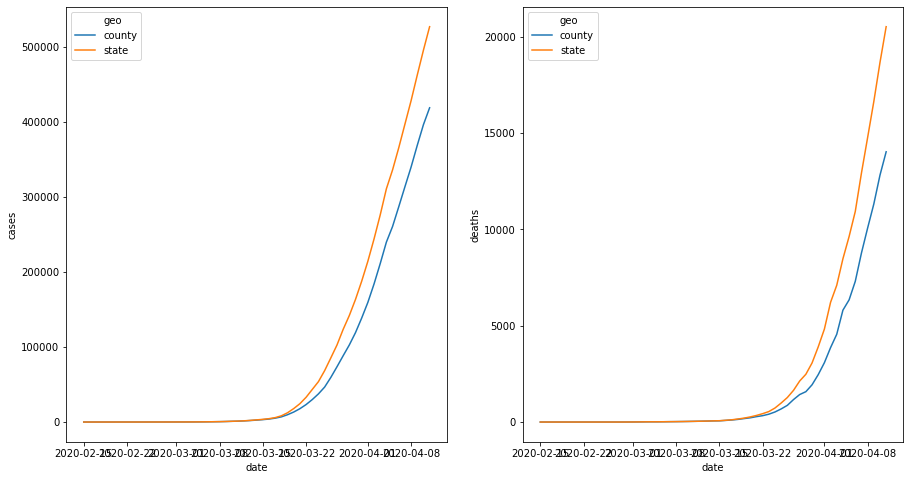

In [27]:
plt_data = full_data.groupby(['geo','date'])['cases','deaths'].sum().reset_index()
f, ax = plt.subplots(1,2,sharex=True,figsize=(15,8))
sns.lineplot(x='date',y='cases',hue='geo',data=plt_data,ax=ax[0])
sns.lineplot(x='date',y='deaths',hue='geo',data=plt_data,ax=ax[1])


In [28]:
full_data.groupby(['geo','date'])['cases','deaths'].sum().reset_index()

C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,geo,date,cases,deaths
0,county,2020-02-15,15.0,0.0
1,county,2020-02-16,15.0,0.0
2,county,2020-02-17,25.0,0.0
3,county,2020-02-18,25.0,0.0
4,county,2020-02-19,25.0,0.0
...,...,...,...,...
109,state,2020-04-07,396854.0,12926.0
110,state,2020-04-08,428234.0,14772.0
111,state,2020-04-09,462402.0,16634.0
112,state,2020-04-10,495553.0,18666.0


In [29]:
full_data.to_csv('data/compiled_{}'.format(str(datetime.datetime.now().date())),index=False)

# Lag mobility data

In [37]:
full_data.columns.values

array(['country', 'region', 'date', 'asterisk_food_drugs',
       'asterisk_homes', 'asterisk_park', 'asterisk_shop',
       'asterisk_transit', 'asterisk_work', 'value_food_drugs',
       'value_homes', 'value_park', 'value_shop', 'value_transit',
       'value_work', 'source', 'State', 'Region', 'FIPS',
       'Population, 2014 estimate', 'Population, 2013 estimate',
       'Population, 2010 (April 1) estimates base',
       'Population, percent change - April 1, 2010 to July 1, 2014',
       'Population, percent change - April 1, 2010 to July 1, 2013',
       'Population, 2010', 'Persons under 5 years, percent, 2013',
       'Persons under 18 years, percent, 2013',
       'Persons 65 years and over, percent, 2013',
       'Female persons, percent, 2013', 'White alone, percent, 2013',
       'Black or African American alone, percent, 2013',
       'American Indian and Alaska Native alone, percent, 2013',
       'Asian alone, percent, 2013',
       'Native Hawaiian and Other Pacific I